# Compilation methods for Hamiltonian simulation circuits
Estimated QPU usage: no execution was done in this tutorial because it is focused on the transpilation process.

{/* cspell:ignore Rustiq, nshuffles, edgecolors, edgecolor, Hamlib, Benchpress, Brugière, Goubault, Martiel, Dubal, Lishman, Ivrii, fontweight, fontsize, textprops, wedgeprops, startangle, autopct */}

## Background

Quantum circuit compilation is a crucial step in the quantum computing workflow. It involves transforming a high-level quantum algorithm into a physical quantum circuit that adheres to the constraints of the target quantum hardware. Effective compilation can significantly impact the performance of quantum algorithms by reducing circuit depth, gate count, and execution time. This tutorial explores three distinct approaches to quantum circuit compilation in Qiskit, showcasing their strengths and applications through practical examples.

The goal of this tutorial is to teach users how to apply and evaluate three compilation methods in Qiskit: the SABRE transpiler, the AI-powered transpiler, and the Rustiq plugin. Users will learn how to use each method effectively and how to benchmark their performance across different quantum circuits. By the end of this tutorial, users will be able to choose and tailor compilation strategies based on specific optimization goals such as reducing circuit depth, minimizing gate count, or improving runtime.

### What you will learn
- **How to use the Qiskit transpiler with SABRE for layout and routing optimization.**
- **How to leverage the AI transpiler for advanced, automated circuit optimization.**
- **How to employ the Rustiq plugin for circuits requiring precise synthesis of operations, particularly in Hamiltonian simulation tasks.**

This tutorial uses three example circuits following the [Qiskit patterns](/docs/guides/intro-to-patterns) workflow to illustrate the performance of each compilation method. By the end of this tutorial, users will be equipped to choose the appropriate compilation strategy based on their specific requirements and constraints.

### Compilation methods overview

#### 1. **Qiskit transpiler with SABRE**
The Qiskit transpiler uses the SABRE (SWAP-based BidiREctional heuristic search) algorithm to optimize circuit layout and routing. SABRE focuses on minimizing SWAP gates and their impact on circuit depth while adhering to hardware connectivity constraints. This method is highly versatile and suitable for general-purpose circuit optimization, providing a balance between performance and computation time. To take advantage of the latest improvements in SABRE, detailed in [\[1\]](https://arxiv.org/abs/2409.08368), you can increase the number of trials (for example, `layout_trials=400, swap_trials=400`). For the purposes of this tutorial, we will use the default values for the number of trials in order to compare to Qiskit's default transpiler.  The advantages and parameter exploration of SABRE are covered in a separate [deep-dive tutorial](/docs/tutorials/transpilation-optimizations-with-sabre).

#### 2. **AI transpiler**

The AI-powered transpiler in Qiskit uses machine learning to predict optimal transpilation strategies by analyzing patterns in circuit structure and hardware constraints to select the best sequence of optimizations for a given input. This method is particularly effective for large-scale quantum circuits, offering a high degree of automation and adaptability to diverse problem types. In addition to general circuit optimization, the AI transpiler can be used with the `AIPauliNetworkSynthesis` pass, which targets Pauli network circuits — blocks composed of H, S, SX, CX, RX, RY, and RZ gates — and applies a reinforcement learning-based synthesis approach. For more information on the AI transpiler and its synthesis strategies, see [\[2\]](https://arxiv.org/abs/2405.13196) and [\[3\]](https://arxiv.org/abs/2503.14448).



#### 3. **Rustiq plugin**
The Rustiq plugin introduces advanced synthesis techniques specifically for `PauliEvolutionGate` operations, which represent Pauli rotations commonly used in Trotterized dynamics. This plugin is valuable for circuits implementing Hamiltonian simulation, such as those used in quantum chemistry and physics problems, where accurate Pauli rotations are essential for simulating problem Hamiltonians effectively. Rustiq offers precise, low-depth circuit synthesis for these specialized operations. For more details about the implementation and performance of Rustiq, please refer to [\[4\]](https://arxiv.org/abs/2404.03280).

By exploring these compilation methods in depth, this tutorial provides users with the tools to enhance the performance of their quantum circuits, paving the way for more efficient and practical quantum computations.

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.3 or later ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime v0.28 or later (`pip install qiskit-ibm-runtime`)
- Qiskit IBM Transpiler (`pip install qiskit-ibm-transpiler`)
- Qiskit AI Transpiler local mode (`pip install qiskit_ibm_ai_local_transpiler`)
- Networkx graph library (`pip install networkx`)

## Setup

In [1]:
from qiskit.circuit import QuantumCircuit, Measure
from qiskit.dagcircuit import DAGInNode, DAGOpNode
from qiskit.transpiler import PassManager, TransformationPass
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import (
    efficient_su2,
    PauliEvolutionGate,
)
from qiskit_ibm_transpiler import generate_ai_pass_manager
from qiskit_ibm_transpiler.ai.synthesis import AIPauliNetworkSynthesis
from qiskit_ibm_transpiler.ai.collection import CollectPauliNetworks
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig
from collections import Counter
from IPython.display import display
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import logging

# Suppress noisy loggers
logging.getLogger("qiskit_ibm_transpiler.wrappers.ai_local_synthesis").setLevel(logging.ERROR)

seed = 42  # Seed for reproducibility

# Part 1: Efficient SU2 Circuit

## Step 1: Map classical inputs to a quantum problem

In this section, we explore the `efficient_su2` circuit, a hardware-efficient ansatz commonly used in variational quantum algorithms (such as VQE) and quantum machine-learning tasks. The circuit consists of alternating layers of single-qubit rotations and entangling gates arranged in a circular pattern, designed to explore the quantum state space effectively while maintaining manageable depth.

We will begin by constructing one `efficient_su2` circuit to demonstrate how to compare different compilation methods. After Part 1, we will expand our analysis to a larger set of circuits, enabling a comprehensive benchmark for evaluating the performance of various compilation techniques.

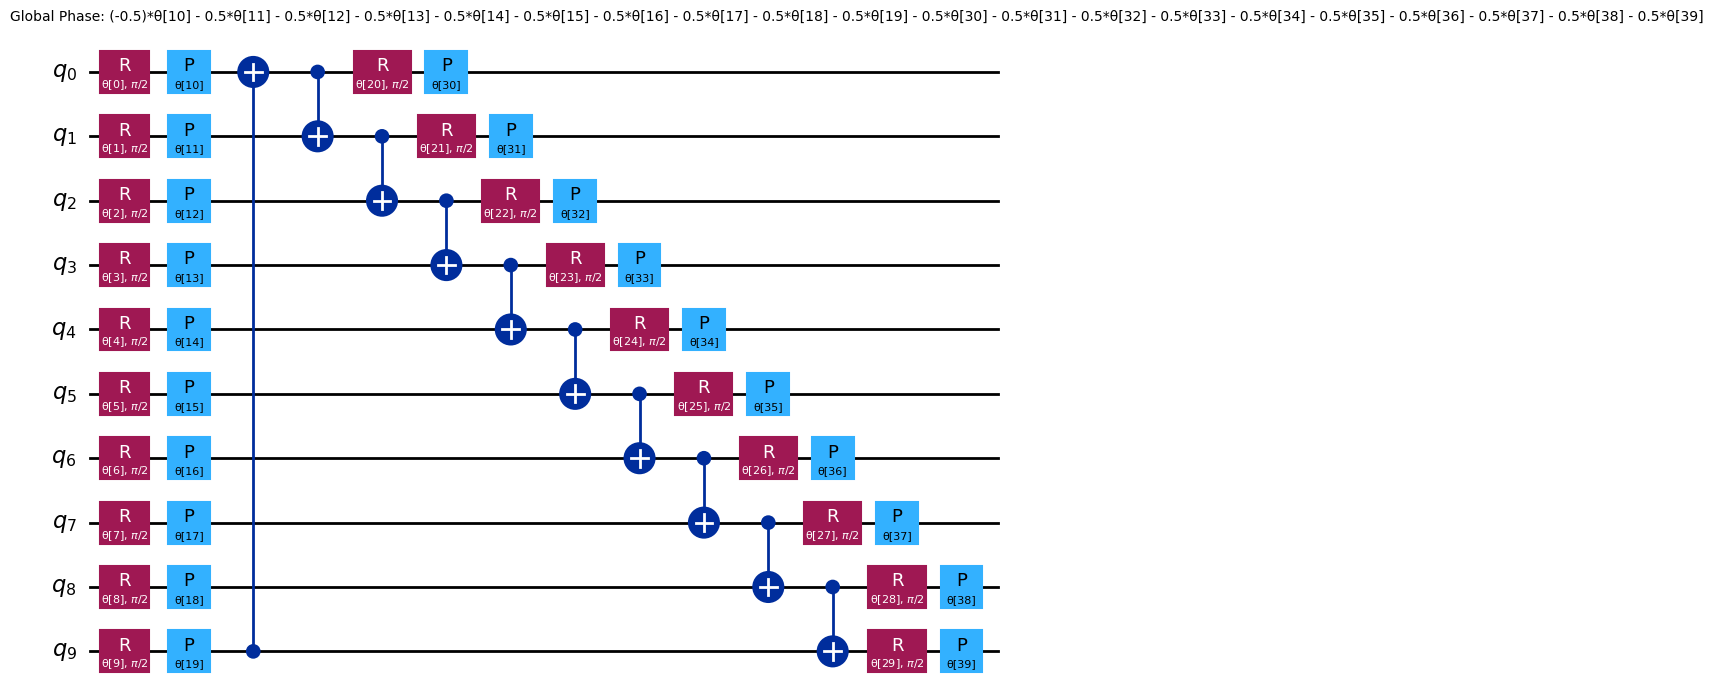

In [2]:
qubit_size = list(range(10, 101, 10)) 
qc_su2_list = [
    efficient_su2(n, entanglement="circular", reps=1)
    .decompose()
    .copy(name=f"SU2_{n}")
    for n in qubit_size
]

# Draw the first circuit
qc_su2_list[0].draw(output="mpl")

## Step 2: Optimize problem for quantum hardware execution

This step is the main focus of the tutorial. Here, we aim to optimize quantum circuits for efficient execution on real quantum hardware. Our primary objective is to reduce circuit depth and gate count, which are key factors in improving execution fidelity and mitigating hardware noise.

- **SABRE transpiler**: Uses Qiskit’s default transpiler with the SABRE layout and routing algorithm.
- **AI transpiler (local mode)**: The standard AI-powered transpiler using local inference and the default synthesis strategy.
- **Rustiq plugin**: A transpiler plugin designed for low-depth compilation tailored to Hamiltonian simulation tasks.

The goal of this step is to compare the results of these methods in terms of the transpiled circuit’s depth and gate count. Another important metric we consider is the transpilation runtime. By analyzing these metrics, we can evaluate the relative strengths of each method and determine which produces the most efficient circuit for execution on the selected hardware.

Note: For the initial SU2 circuit example, we will only compare the SABRE transpiler to the default AI transpiler. However, in the subsequent benchmark using Hamlib circuits, we will compare all three transpilation methods.

In [3]:
# QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.backend("ibm_torino")
print(f"Using backend: {backend}")

qiskit_runtime_service._get_crn_from_instance_name:WARNING:2025-07-30 21:46:30,843: Multiple instances found. Using all matching instances.


Using backend: <IBMBackend('ibm_torino')>


Qiskit transpiler with SABRE:

In [4]:
pm_sabre = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    seed_transpiler=seed
)

AI transpiler:

In [5]:
# Standard AI transpiler pass manager, using the local mode
pm_ai = generate_ai_pass_manager(
    backend=backend,
    optimization_level=3,
    ai_optimization_level=3
)

Rustiq plugin:

In [6]:
hls_config = HLSConfig(
    PauliEvolution=[
        (
            "rustiq",
            {
                "nshuffles": 400,
                "upto_phase": True,
                "fix_clifford": True,
                "preserve_order": False,
                "metric": "depth",
            },
        )
    ]
)
pm_rustiq = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    hls_config=hls_config,
    seed_transpiler=seed,
)

### Transpile and capture metrics

To compare the performance of the compilation methods, we define a function that transpiles the input circuit and captures relevant metrics in a consistent manner. This includes the total circuit depth, overall gate count, and transpilation time.

In addition to these standard metrics, we also record the 2-qubit gate depth, which is a particularly important metric for evaluating execution on quantum hardware. Unlike total depth, which includes all gates, the 2-qubit depth more accurately reflects the circuit's*actual execution duration on hardware. This is because 2-qubit gates typically dominate the time and error budget in most quantum devices. As such, minimizing 2-qubit depth is critical for improving fidelity and reducing decoherence effects during execution.

We will use this function to analyze the performance of the different compilation methods across multiple circuits.


In [7]:
def capture_transpilation_metrics(
    results, pass_manager, circuits, method_name
):
    """
    Capture transpilation metrics for a list of circuits and stores the results in a DataFrame.

    Args:
        results (pd.DataFrame): DataFrame to store the results.
        pass_manager: Pass manager used for transpilation.
        circuits (list): List of quantum circuits to transpile.
        method_name (str): Name of the transpilation method.

    Returns:
        list: List of transpiled circuits.
    """
    transpiled_circuits = []

    for i, qc in enumerate(circuits):
        # Transpile the circuit
        start_time = time.time()
        transpiled_qc = pass_manager.run(qc)
        end_time = time.time()

        # Needed for AI transpiler to be consistent with other methods
        transpiled_qc = transpiled_qc.decompose(gates_to_decompose=["swap"])

        # Collect metrics
        transpilation_time = end_time - start_time
        circuit_depth = transpiled_qc.depth(
            lambda x: x.operation.num_qubits == 2
        )
        circuit_size = transpiled_qc.size()

        # Append results to DataFrame
        results.loc[len(results)] = {
            "method": method_name,
            "qc_name": qc.name,
            "qc_index": i,
            "num_qubits": qc.num_qubits,
            "ops": transpiled_qc.count_ops(),
            "depth": circuit_depth,
            "size": circuit_size,
            "runtime": transpilation_time,
        }
        transpiled_circuits.append(transpiled_qc)
        print(
            f"Transpiled circuit index {i} ({qc.name}) in {transpilation_time:.2f} seconds with method {method_name}, "
            f"depth {circuit_depth}, and size {circuit_size}."
        )

    return transpiled_circuits

In [8]:
results_su2 = pd.DataFrame(
    columns=[
        "method",
        "qc_name",
        "qc_index",
        "num_qubits",
        "ops",
        "depth",
        "size",
        "runtime",
    ]
)

tqc_sabre = capture_transpilation_metrics(
    results_su2, pm_sabre, qc_su2_list, "sabre"
)
tqc_ai = capture_transpilation_metrics(
    results_su2, pm_ai, qc_su2_list, "ai"
)

Transpiled circuit index 0 (SU2_10) in 0.06 seconds with method sabre, depth 13, and size 167.
Transpiled circuit index 1 (SU2_20) in 0.24 seconds with method sabre, depth 20, and size 299.
Transpiled circuit index 2 (SU2_30) in 10.72 seconds with method sabre, depth 72, and size 627.
Transpiled circuit index 3 (SU2_40) in 16.16 seconds with method sabre, depth 40, and size 599.
Transpiled circuit index 4 (SU2_50) in 76.89 seconds with method sabre, depth 77, and size 855.
Transpiled circuit index 5 (SU2_60) in 86.12 seconds with method sabre, depth 60, and size 899.
Transpiled circuit index 6 (SU2_70) in 94.46 seconds with method sabre, depth 79, and size 1085.
Transpiled circuit index 7 (SU2_80) in 69.05 seconds with method sabre, depth 80, and size 1199.
Transpiled circuit index 8 (SU2_90) in 88.25 seconds with method sabre, depth 105, and size 1420.
Transpiled circuit index 9 (SU2_100) in 83.80 seconds with method sabre, depth 100, and size 1499.
Transpiled circuit index 0 (SU2_10)

Display transpiled results of one of the circuit.

Sabre transpilation


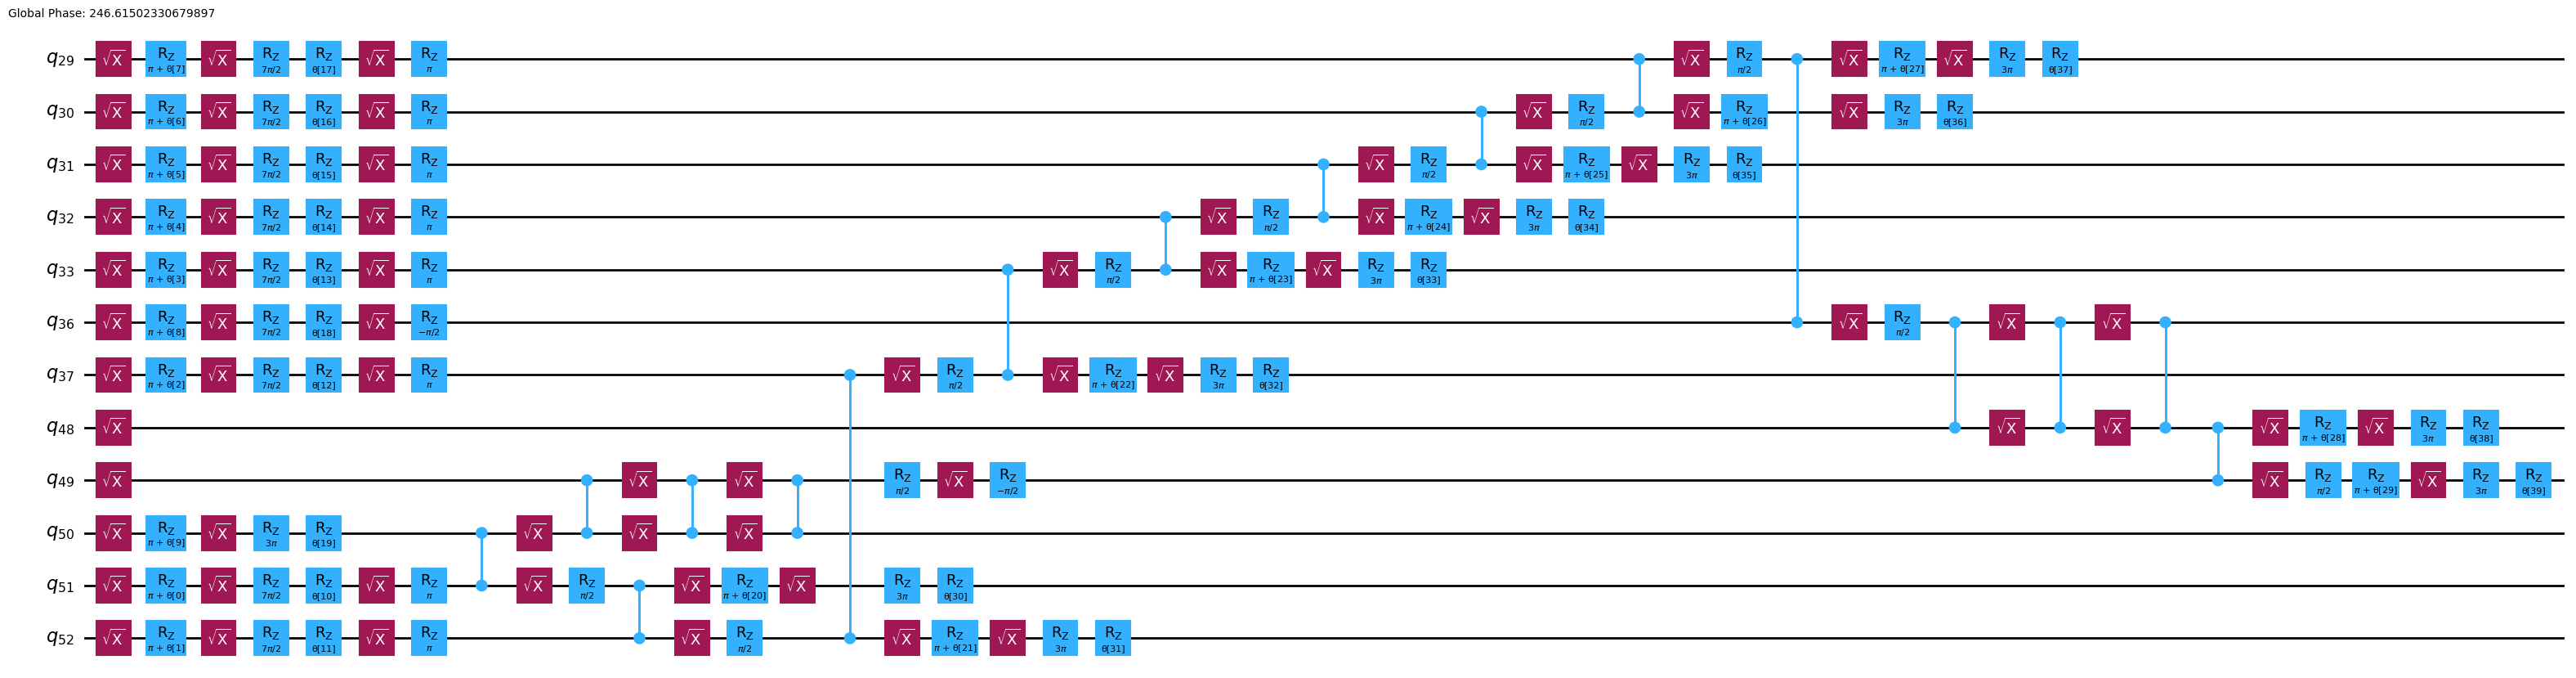

AI transpilation


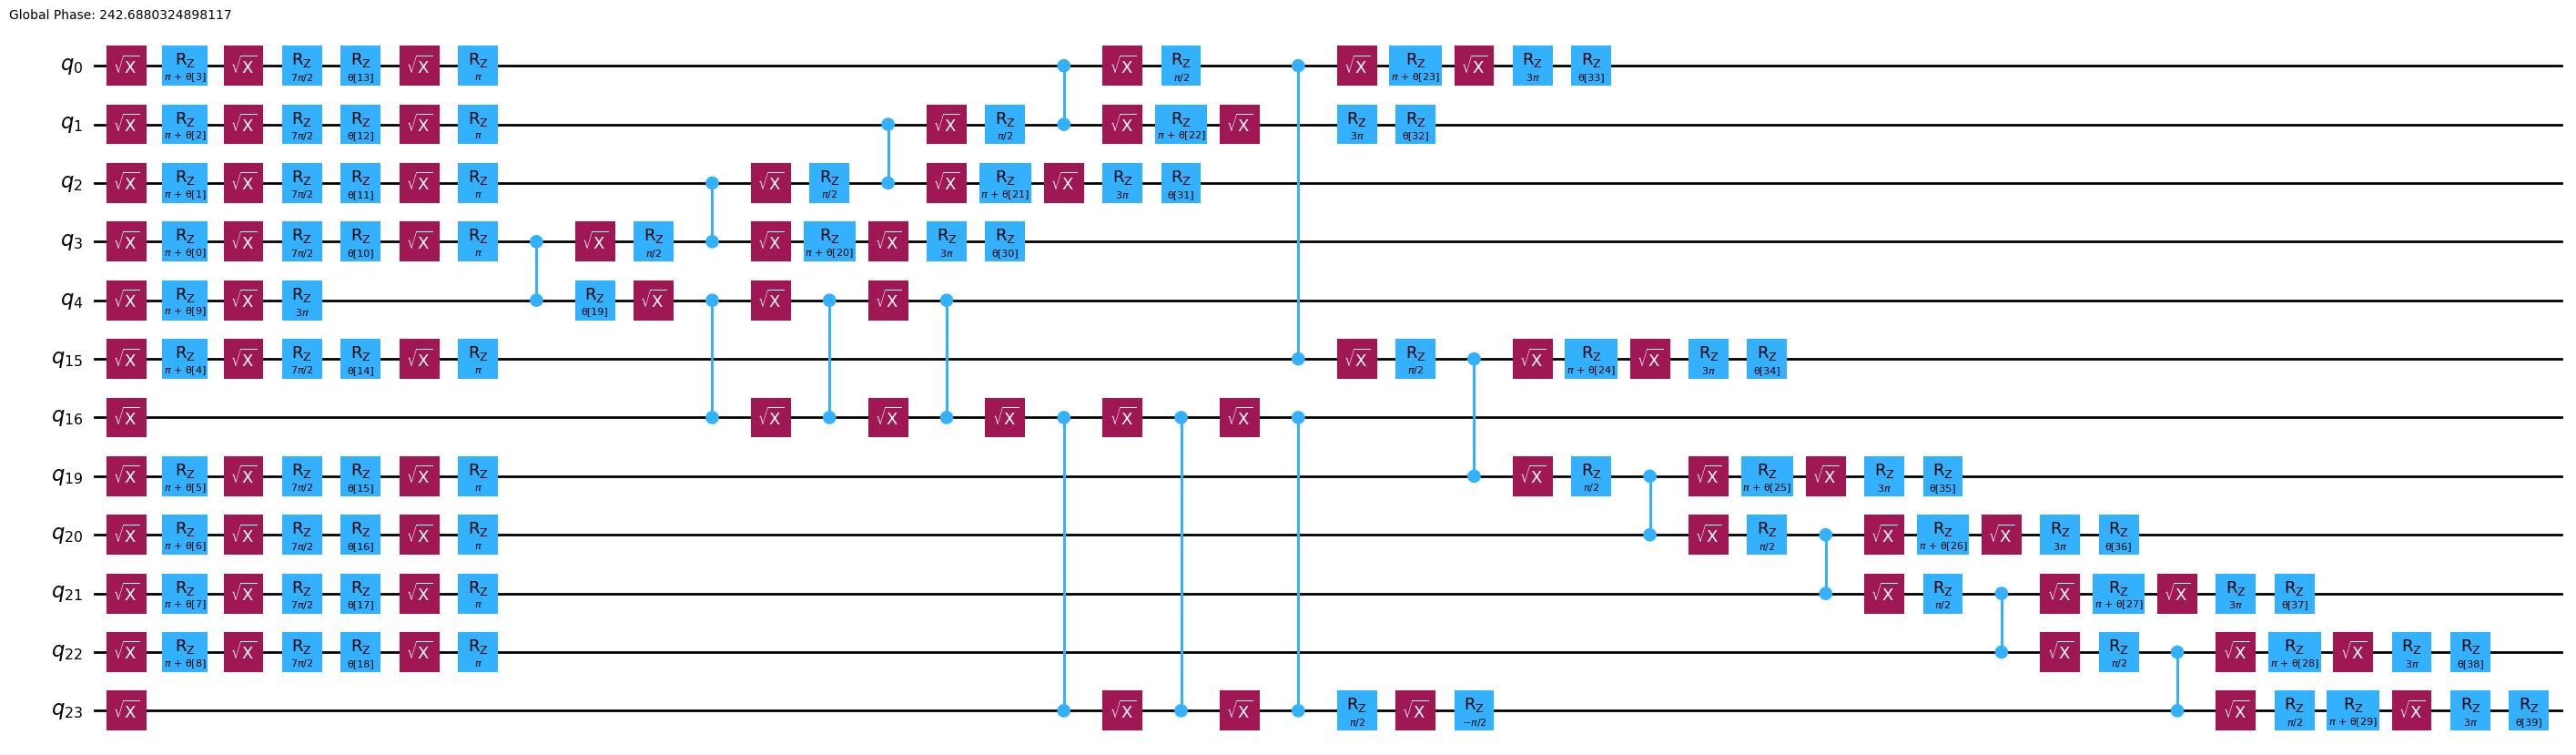

In [9]:
print("Sabre transpilation")
display(tqc_sabre[0].draw("mpl", fold=-1, idle_wires=False))
print("AI transpilation")
display(tqc_ai[0].draw("mpl", fold=-1, idle_wires=False))

Results table:

In [10]:
summary_su2 = (
    results_su2.groupby("method")[["depth", "size", "runtime"]]
    .mean()
    .round(2)
)
print(summary_su2)

results_su2

        depth   size  runtime
method                       
ai       56.4  852.5    45.89
sabre    64.6  864.9    52.57


,method,qc_name,qc_index,num_qubits,ops,depth,size,runtime
0,sabre,SU2_10,0,10,"{'rz': 81, 'sx': 70, 'cz': 16}",13,167,0.058845
1,sabre,SU2_20,1,20,"{'rz': 160, 'sx': 119, 'cz': 20}",20,299,0.238217
2,sabre,SU2_30,2,30,"{'sx': 295, 'rz': 242, 'cz': 90}",72,627,10.723922
3,sabre,SU2_40,3,40,"{'rz': 320, 'sx': 239, 'cz': 40}",40,599,16.159262
4,sabre,SU2_50,4,50,"{'rz': 402, 'sx': 367, 'cz': 86}",77,855,76.886604
5,sabre,SU2_60,5,60,"{'rz': 480, 'sx': 359, 'cz': 60}",60,899,86.118255
6,sabre,SU2_70,6,70,"{'rz': 562, 'sx': 441, 'cz': 82}",79,1085,94.458287
7,sabre,SU2_80,7,80,"{'rz': 640, 'sx': 479, 'cz': 80}",80,1199,69.048184
8,sabre,SU2_90,8,90,"{'rz': 721, 'sx': 585, 'cz': 114}",105,1420,88.254809
9,sabre,SU2_100,9,100,"{'rz': 800, 'sx': 599, 'cz': 100}",100,1499,83.795482


### Results graph

As we define a function to consistently capture metrics, we will also define one to graph the metrics. Here, we will plot the two-qubit depth, gate count, and runtime for each compilation method across the circuits.

In [11]:
def plot_transpilation_metrics(results, overall_title, x_axis="qc_index"):
    """
    Plots transpilation metrics (depth, size, runtime) for different transpilation methods.

    Parameters:
        results (DataFrame): Data containing columns ['num_qubits', 'method', 'depth', 'size', 'runtime']
        overall_title (str): The title of the overall figure.
        x_axis (str): The x-axis label, either 'num_qubits' or 'qc_index'.
    """

    fig, axs = plt.subplots(1, 3, figsize=(24, 6))
    metrics = ["depth", "size", "runtime"]
    titles = ["Circuit Depth", "Circuit Size", "Transpilation Runtime"]
    y_labels = ["Depth", "Size (Gate Count)", "Runtime (s)"]

    methods = results["method"].unique()
    colors = plt.colormaps["tab10"]
    markers = ["o", "^", "s", "D", "P", "*", "X", "v"]
    color_list = [colors(i % colors.N) for i in range(len(methods))]
    color_map = {method: color_list[i] for i, method in enumerate(methods)}
    marker_map = {
        method: markers[i % len(markers)] for i, method in enumerate(methods)
    }
    jitter_factor = 0.1  # Small x-axis jitter for visibility
    handles, labels = [], []  # Unique handles for legend

    # Plot each metric
    for i, metric in enumerate(metrics):
        for method in methods:
            method_data = results[results["method"] == method]

            # Introduce slight jitter to avoid exact overlap
            jitter = np.random.uniform(
                -jitter_factor, jitter_factor, len(method_data)
            )

            scatter = axs[i].scatter(
                method_data[x_axis] + jitter,
                method_data[metric],
                color=color_map[method],
                label=method,
                marker=marker_map[method],
                alpha=0.7,
                edgecolors="black",
                s=80,
            )

            if method not in labels:
                handles.append(scatter)
                labels.append(method)

        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_axis)
        axs[i].set_ylabel(y_labels[i])
        axs[i].grid(axis="y", linestyle="--", alpha=0.7)
        axs[i].tick_params(axis="x", rotation=45)
        axs[i].set_xticks(sorted(results[x_axis].unique()))

    fig.suptitle(overall_title, fontsize=16)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper right",
        bbox_to_anchor=(1.05, 1),
    )

    plt.tight_layout()
    plt.show()

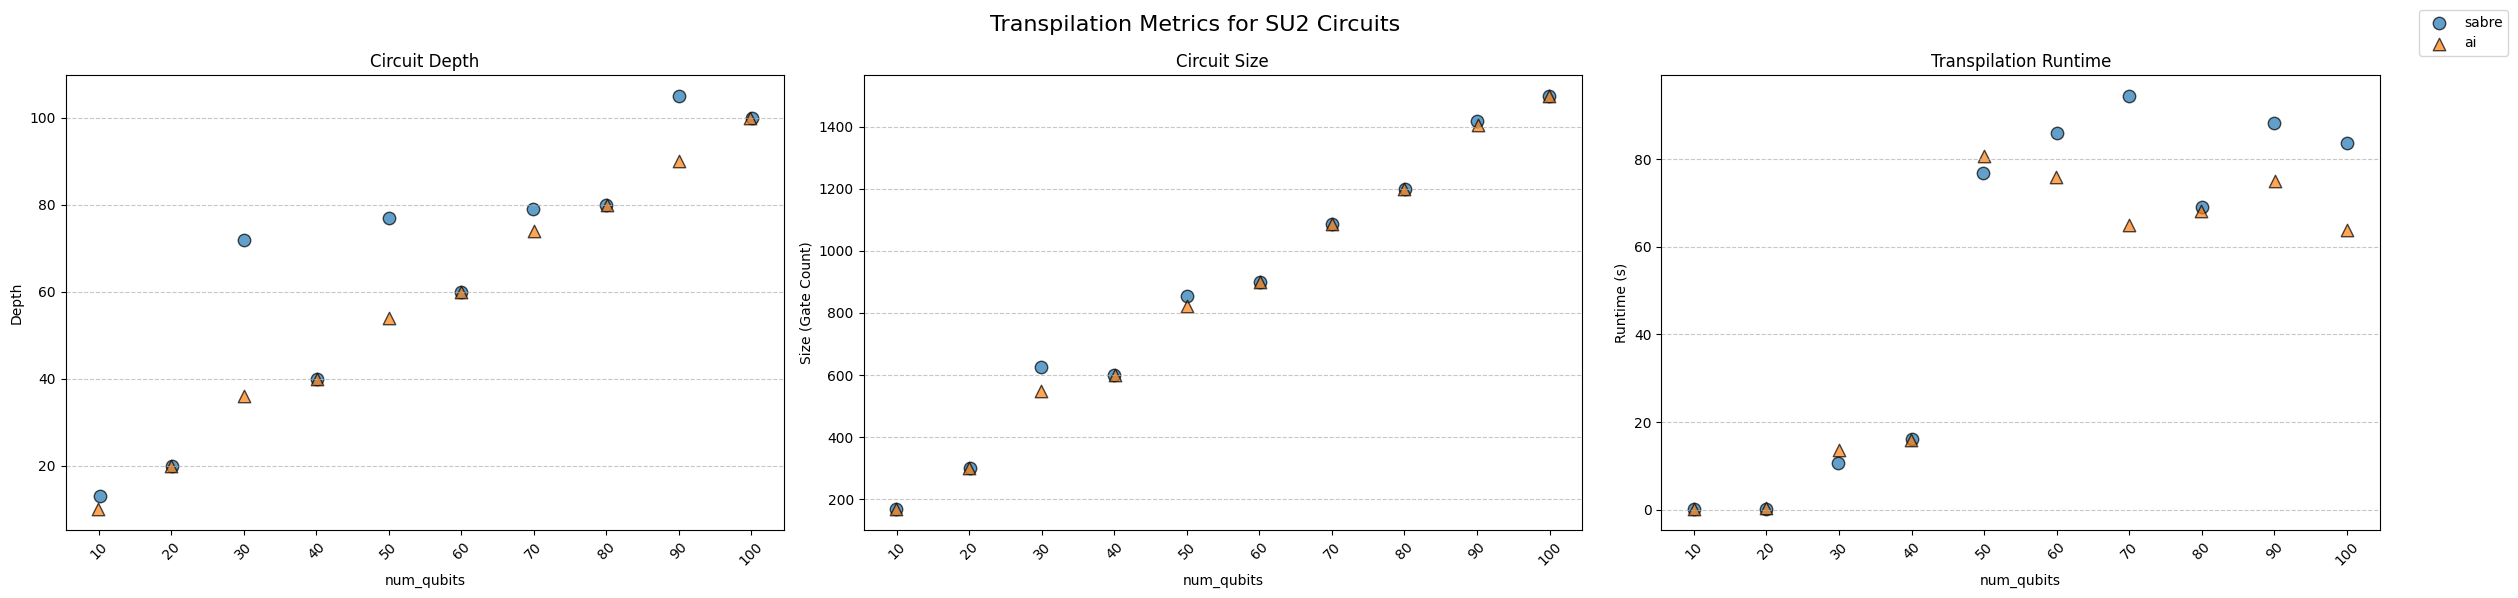

In [12]:
plot_transpilation_metrics(
    results_su2, "Transpilation Metrics for SU2 Circuits", x_axis="num_qubits"
)

### Analysis of SU2 circuit compilation results

In this experiment, we compare two transpilation methods — Qiskit's SABRE transpiler and the AI-powered transpiler — on a set of `efficient_su2` circuits. Since these circuits do not include any `PauliEvolutionGate` operations, the Rustiq plugin is not included in this comparison.

On average, the AI transpiler performs better in terms of circuit depth, with a greater than 10% improvement across the full range of SU2 circuits. For gate count (circuit size) and transpilation runtime, both methods yield similar results overall.

However, inspecting the individual data points reveals a deeper insight:
- For most qubit sizes, both SABRE and AI produce nearly identical results, suggesting that in many cases, both methods converge to similarly efficient solutions.
- For certain circuit sizes, specifically at 30, 50, 70, and 90 qubits, the AI transpiler finds significantly shallower circuits than SABRE. This indicates that AI's learning-based approach is able to discover more optimal layouts or routing paths in cases where the SABRE heuristic does not.

This behavior highlights an important takeaway:  
> While SABRE and AI often produce comparable results, the AI transpiler can occasionally discover much better solutions, particularly in terms of depth, which can lead to significantly improved performance on hardware.

# Part 2: Hamiltonian simulation circuit

## Step 1: Investigate circuits with `PauliEvolutionGate`

In this section, we investigate quantum circuits constructed using `PauliEvolutionGate`, which enables efficient simulation of Hamiltonians. We will analyze how different compilation methods optimize these circuits across various Hamiltonians.

### Hamiltonians used in the benchmark

The Hamiltonians used in this benchmark describe pairwise interactions between qubits, including terms such as $ZZ$, $XX$, and $YY$. These Hamiltonians are commonly used in quantum chemistry, condensed matter physics, and materials science, where they model systems of interacting particles.

For reference, users can explore a broader set of Hamiltonians in this paper: [Efficient Hamiltonian Simulation on Noisy Quantum Devices](https://arxiv.org/pdf/2306.13126).

### Benchmark source: Hamlib and Benchpress

The circuits used in this benchmark are drawn from the [Hamlib benchmark repository](https://github.com/SRI-International/QC-App-Oriented-Benchmarks/tree/master/hamlib), which contains realistic Hamiltonian simulation workloads.

These same circuits were previously benchmarked using [Benchpress](https://github.com/Qiskit/benchpress), an open-source framework for evaluating quantum transpilation performance. By using this standardized set of circuits, we can directly compare the effectiveness of different compilation strategies on representative simulation problems.

Hamiltonian simulation is a foundational task in quantum computing, with applications in molecular simulations, optimization problems, and quantum many-body physics. Understanding how different compilation methods optimize these circuits can help users improve practical execution of such circuits on near-term quantum devices.

Number of Hamiltonian circuits: 35


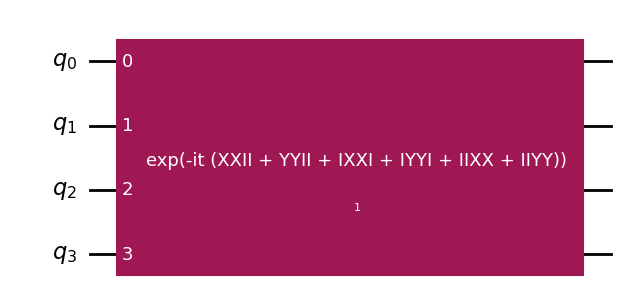

In [13]:

# Obtain the Hamiltonian JSON from the benchpress repository
url = "https://raw.githubusercontent.com/Qiskit/benchpress/e7b29ef7be4cc0d70237b8fdc03edbd698908eff/benchpress/hamiltonian/hamlib/100_representative.json"
response = requests.get(url)
response.raise_for_status()  # Raise an error if download failed
ham_records = json.loads(response.text)
# Remove circuits that are too large for the backend
ham_records = [
    h for h in ham_records if h["ham_qubits"] <= backend.num_qubits
]
# Remove the circuits that are large to save transpilation time
ham_records = sorted(ham_records, key=lambda x: x["ham_terms"])[:35]

qc_ham_list = []
for h in ham_records:
    terms = h["ham_hamlib_hamiltonian_terms"]
    coeff = h["ham_hamlib_hamiltonian_coefficients"]
    num_qubits = h["ham_qubits"]
    name = h["ham_problem"]

    evo_gate = PauliEvolutionGate(SparsePauliOp(terms, coeff))

    qc_ham = QuantumCircuit(num_qubits)
    qc_ham.name = name

    qc_ham.append(evo_gate, range(num_qubits))
    qc_ham_list.append(qc_ham)
print(f"Number of Hamiltonian circuits: {len(qc_ham_list)}")

# Draw the first Hamiltonian circuit
qc_ham_list[0].draw("mpl", fold=-1)

## Step 2: Optimize problem for quantum hardware execution

As in the previous example, we will use the same backend to ensure consistency in our comparisons. Since the pass managers (`pm_sabre`, `pm_ai`, and `pm_rustiq`) have already been initialized, we can directly proceed with transpiling the Hamiltonian circuits using each method.

This step focuses solely on performing the transpilation and recording the resulting circuit metrics, including depth, gate count, and transpilation runtime. By analyzing these results, we aim to determine the efficiency of each transpilation method for this type of circuit.

Transpile and capture metrics:

In [14]:
results_ham = pd.DataFrame(
    columns=[
        "method",
        "qc_name",
        "qc_index",
        "num_qubits",
        "ops",
        "depth",
        "size",
        "runtime",
    ]
)

tqc_sabre = capture_transpilation_metrics(
    results_ham, pm_sabre, qc_ham_list, "sabre"
)
tqc_ai = capture_transpilation_metrics(
    results_ham, pm_ai, qc_ham_list, "ai"
)
tqc_rustiq = capture_transpilation_metrics(
    results_ham, pm_rustiq, qc_ham_list, "rustiq"
)

Transpiled circuit index 0 (all-vib-o3) in 0.02 seconds with method sabre, depth 6, and size 58.
Transpiled circuit index 1 (all-vib-c2h) in 1.10 seconds with method sabre, depth 2, and size 39.
Transpiled circuit index 2 (all-vib-bh) in 0.01 seconds with method sabre, depth 3, and size 30.
Transpiled circuit index 3 (all-vib-c2h) in 0.03 seconds with method sabre, depth 18, and size 115.
Transpiled circuit index 4 (graph-gnp_k-2) in 0.02 seconds with method sabre, depth 24, and size 129.
Transpiled circuit index 5 (all-vib-fccf) in 0.05 seconds with method sabre, depth 14, and size 134.
Transpiled circuit index 6 (all-vib-hno) in 8.39 seconds with method sabre, depth 6, and size 174.
Transpiled circuit index 7 (all-vib-bhf2) in 3.92 seconds with method sabre, depth 22, and size 220.
Transpiled circuit index 8 (LiH) in 0.03 seconds with method sabre, depth 67, and size 290.
Transpiled circuit index 9 (uf20-ham) in 0.04 seconds with method sabre, depth 50, and size 340.
Transpiled circu

Results table (skipping visualization as the output circuits are very large):

In [15]:
summary_ham = (
    results_ham.groupby("method")[["depth", "size", "runtime"]]
    .mean()
    .round(2)
)
print(summary_ham)

results_ham

         depth     size  runtime
method                          
ai      316.86  2181.26     5.97
rustiq  281.94  2268.80     3.86
sabre   337.97  2120.14     3.07


,method,qc_name,qc_index,num_qubits,ops,depth,size,runtime
0,sabre,all-vib-o3,0,4,"{'rz': 28, 'sx': 24, 'cz': 6}",6,58,0.016597
1,sabre,all-vib-c2h,1,4,"{'rz': 17, 'sx': 16, 'cz': 4, 'x': 2}",2,39,1.102089
2,sabre,all-vib-bh,2,2,"{'sx': 14, 'rz': 13, 'cz': 3}",3,30,0.011042
3,sabre,all-vib-c2h,3,3,"{'sx': 46, 'rz': 45, 'cz': 18, 'x': 6}",18,115,0.025816
4,sabre,graph-gnp_k-2,4,4,"{'sx': 49, 'rz': 47, 'cz': 24, 'x': 9}",24,129,0.023077
...,...,...,...,...,...,...,...,...
100,rustiq,flat100-ham,30,90,"{'sx': 2709, 'cz': 1379, 'rz': 817, 'x': 5}",279,4910,0.309448
101,rustiq,uf100-ham,31,46,"{'sx': 6180, 'cz': 3120, 'rz': 1303, 'x': 4}",1138,10607,0.380977
102,rustiq,OH,32,10,"{'sx': 3330, 'cz': 1704, 'rz': 1455, 'x': 23}",1148,6512,0.383564
103,rustiq,HF,33,10,"{'sx': 3213, 'cz': 1620, 'rz': 1406, 'x': 17}",1090,6256,0.368578


Visualize performance based on circuit index:

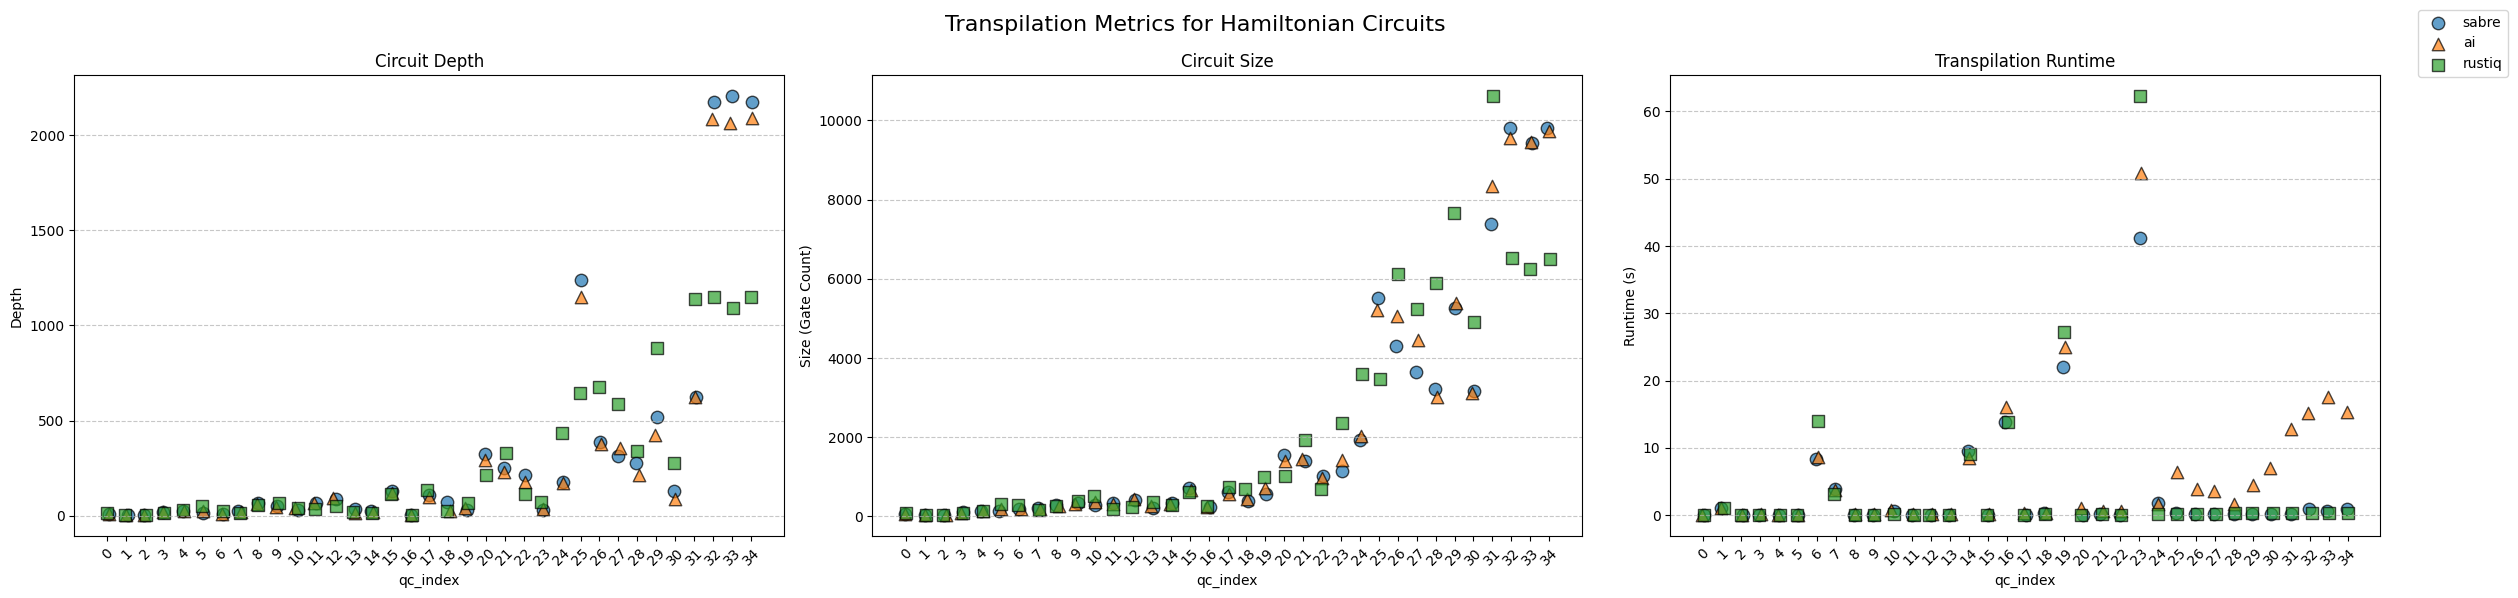

In [16]:
plot_transpilation_metrics(
    results_ham, "Transpilation Metrics for Hamiltonian Circuits"
)

Visualize the percentage of circuits for which each method performed best.

Best-performing methods based on depth:
    ai: 16 circuit(s)
    rustiq: 16 circuit(s)
    sabre: 10 circuit(s)


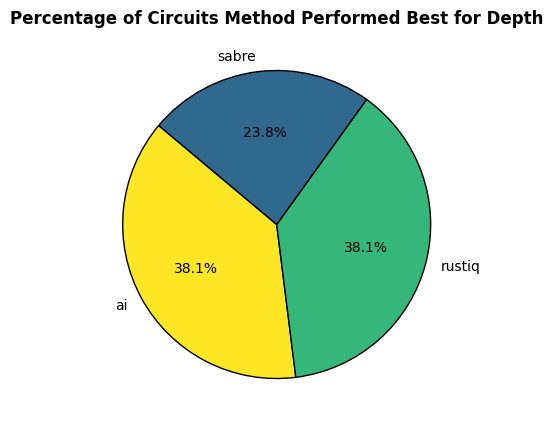

Best-performing methods based on size:
    sabre: 18 circuit(s)
    rustiq: 14 circuit(s)
    ai: 10 circuit(s)


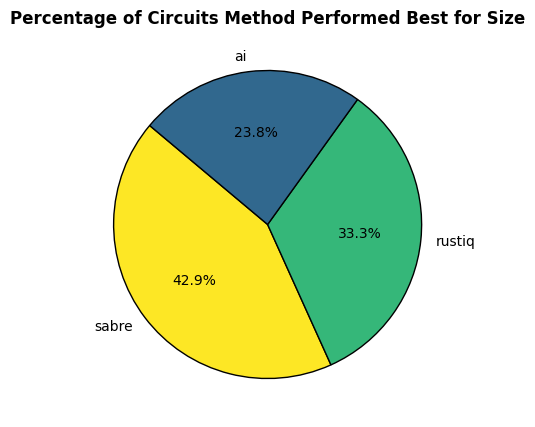

In [17]:
def analyze_and_plot_best_methods(results, metric):
    """
    Analyze the best-performing methods for a given metric and plot a pie chart.

    Parameters:
        results (DataFrame): The input DataFrame containing method performance data.
        metric (str): The metric to evaluate ("depth" or "size").
    """
    method_counts = Counter()
    for qc_idx, group in results.groupby("qc_index"):
        min_value = group[metric].min()

        # Find all methods that achieved this minimum value
        best_methods = group[group[metric] == min_value]["method"]
        # Update counts for all best methods (handling ties)
        method_counts.update(best_methods)
    best_method_counts = dict(
        sorted(method_counts.items(), key=lambda x: x[1], reverse=True)
    )

    # Print summary
    print(f"Best-performing methods based on {metric}:")
    for method, count in best_method_counts.items():
        print(f"    {method}: {count} circuit(s)")

    # Plot pie chart
    num_methods = len(best_method_counts)
    colors = plt.cm.viridis_r(range(0, 256, 256 // num_methods))
    plt.figure(figsize=(5, 5))
    plt.pie(
        best_method_counts.values(),
        labels=best_method_counts.keys(),
        autopct="%1.1f%%",
        startangle=140,
        wedgeprops={"edgecolor": "black"},
        textprops={"fontsize": 10},
        colors=colors,
    )
    plt.title(
        f"Percentage of Circuits Method Performed Best for {metric.capitalize()}",
        fontsize=12,
        fontweight="bold",
    )
    plt.show()


analyze_and_plot_best_methods(results_ham, "depth")
analyze_and_plot_best_methods(results_ham, "size")

### Analysis of Hamiltonian circuit compilation results

In this section, we evaluate the performance of three transpilation methods — SABRE, the AI-powered transpiler, and Rustiq — on quantum circuits constructed with `PauliEvolutionGate`, which are commonly used in Hamiltonian simulation tasks.

Rustiq performed best on average in terms of circuit depth**, achieving approximately 20% lower depth than SABRE. This is expected, as Rustiq is specifically designed to synthesize `PauliEvolutionGate` operations with optimized, low-depth decomposition strategies. Furthermore, the depth plot shows that as the circuits scale in size and complexity, Rustiq scales most effectively, maintaining significantly lower depth than both AI and SABRE on larger circuits.

AI transpiler showed strong and consistent performance for circuit depth, consistently outperforming SABRE across most circuits. However, it incurred the highest runtime, especially on larger circuits, which may limit its practicality in time-sensitive workloads. Its scalability in runtime remains a key limitation, even though it offers solid improvements in depth.

SABRE, while producing the highest average depth, achieved the lowest average gate count, closely followed by the AI transpiler. This aligns with the design of SABRE’s heuristic, which prioritizes minimizing gate count directly. Rustiq, despite its strength in lowering depth, had the highest average gate count, which is a notable trade-off to consider in applications where circuit size matters more than circuit duration.

### Summary 

While the AI transpiler generally delivers better results than SABRE, particularly in circuit depth, the takeaway should not simply be "always use the AI transpiler." There are important nuances to consider:

- **AI transpiler** is typically reliable and provides depth-optimized circuits, but it comes with trade-offs in runtime, and also has other limitations, including supported coupling maps and synthesis capabilities. These are detailed in the [Qiskit Transpiler Service documentation](https://quantum.cloud.ibm.com/docs/en/guides/qiskit-transpiler-service).
  
- In some cases, particularly with very large or hardware-specific circuits, the AI transpiler may not be as effective. In these cases, the default SABRE transpiler remains extremely reliable and can be further optimized by adjusting its parameters (see the [SABRE optimization tutorial](https://quantum.cloud.ibm.com/docs/tutorials/transpilation-optimizations-with-sabre)).

- It's also important to consider circuit structure when choosing a method. For example, `rustiq` is purpose-built for circuits involving `PauliEvolutionGate` and often yields the best performance for Hamiltonian simulation problems.

**Recommendation:**  
> There is no one-size-fits-all transpilation strategy. Users are encouraged to understand the structure of their circuit and test multiple transpilation methods — including AI, SABRE, and specialized tools like Rustiq — to find the most efficient solution for their specific problem and hardware constraints.


## Step 3: Execute using Qiskit primitives

As this tutorial focuses on transpilation, no experiments are executed on a quantum device. The goal is to leverage the optimizations from Step 2 to obtain a transpiled circuit with reduced depth and gate count.

## Step 4: Post-process and return result in desired classical format

Since there is no execution for this notebook, there are no results to post-process.

## References
[1] "LightSABRE: A Lightweight and Enhanced SABRE Algorithm". H. Zou, M. Treinish, K. Hartman, A. Ivrii, J. Lishman et al. https://arxiv.org/abs/2409.08368

[2] "Practical and efficient quantum circuit synthesis and transpiling with Reinforcement Learning". D. Kremer, V. Villar, H. Paik, I. Duran, I. Faro, J. Cruz-Benito et al. https://arxiv.org/abs/2405.13196

[3] "Pauli Network Circuit Synthesis with Reinforcement Learning". A. Dubal,  D. Kremer, S. Martiel, V. Villar, D. Wang, J. Cruz-Benito et al. https://arxiv.org/abs/2503.14448

[4] "Faster and shorter synthesis of Hamiltonian simulation circuits". T. Goubault de Brugière, S. Martiel et al. https://arxiv.org/abs/2404.03280